# PCA Analysis Breast Cancer

You are tasked with developing a machine learning model to classify breast cancer tumors as either benign (non-cancerous) or malignant (cancerous) based on features extracted from breast cancer biopsies.The dataset you will be working with is the Breast Cancer Wisconsin (Diagnostic) dataset, available in sklearn. This dataset contains a total of 569 instances with 30 feature attributes computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. The target variable is binary, with '0' indicating benign tumors and '1' indicating malignant tumors. 

To complete the task you need to: 

1. Principal Component Analysis (PCA) for dimensionality reduction and then train a classifier on the reduced dataset. Remember to train the chosen model on the PCA-transformed training data. 
2. Evaluate the model's performance using appropriate metrics (e.g., accuracy, precision, recall, F1-score, confusion matrix, etc.) on the test dataset.
3. Visualize the results, such as the confusion matrix, to assess the model's performance in classifying benign and malignant tumors.
4. Summarize the findings and the effectiveness of PCA in reducing dimensionality for this classification task.

In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import RocCurveDisplay

dataset = load_breast_cancer()

In [36]:
X_data = dataset.data
Y_data = dataset.target

In [37]:
dfX = pd.DataFrame(X_data, columns=dataset.feature_names)
dfY = pd.DataFrame(Y_data, columns=['target'])

In [38]:
dfX.shape
df = dfX.copy()
df['target'] = dfY

In [39]:
df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')

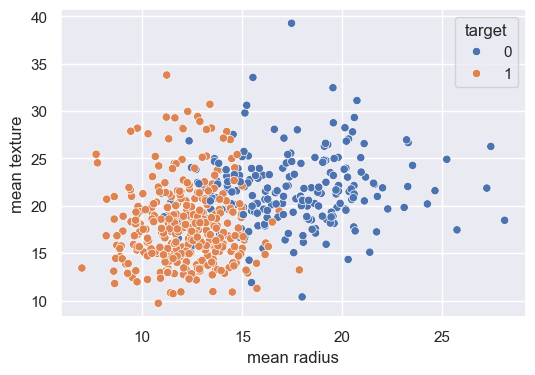

In [40]:
sns.set_theme(rc={'figure.figsize':(6, 4)})
sns.scatterplot(df, x = 'mean radius', y = 'mean texture', hue='target');

In [41]:
X_std = StandardScaler().fit_transform(dfX)
X_rank = np.linalg.matrix_rank(np.cov(X_std))

X_rank

29

In [42]:
L_linspace = np.linspace(1, X_rank, 10, dtype=int)

L_linspace

array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 29])

In [43]:
RMSE = []

for index, L in enumerate(L_linspace):
    pca = PCA(n_components=L)
    X_transformed = pca.fit_transform(X_std)
    X_proj = pca.inverse_transform(X_transformed)
    RMSE.append(mean_squared_error(X_std, X_proj, squared=False))

In [44]:
pca.components_.shape

(29, 30)

In [45]:
eigenvals = pca.explained_variance_
eigenvals # ? - 29 eigenvalues for the entire matrix

array([1.33049908e+01, 5.70137460e+00, 2.82291016e+00, 1.98412752e+00,
       1.65163324e+00, 1.20948224e+00, 6.76408882e-01, 4.77456255e-01,
       4.17628782e-01, 3.51310875e-01, 2.94433153e-01, 2.61621161e-01,
       2.41782421e-01, 1.57286149e-01, 9.43006956e-02, 8.00034045e-02,
       5.95036135e-02, 5.27114222e-02, 4.95647002e-02, 3.12142606e-02,
       3.00256631e-02, 2.74877113e-02, 2.43836914e-02, 1.80867940e-02,
       1.55085271e-02, 8.19203712e-03, 6.91261258e-03, 1.59213600e-03,
       7.50121413e-04])

In [46]:
var_explained = pca.explained_variance_ratio_
var_explained # ? - How much does each eigenvector explain? 44%, 19%, 9% ...

array([4.42720256e-01, 1.89711820e-01, 9.39316326e-02, 6.60213492e-02,
       5.49576849e-02, 4.02452204e-02, 2.25073371e-02, 1.58872380e-02,
       1.38964937e-02, 1.16897819e-02, 9.79718988e-03, 8.70537901e-03,
       8.04524987e-03, 5.23365745e-03, 3.13783217e-03, 2.66209337e-03,
       1.97996793e-03, 1.75395945e-03, 1.64925306e-03, 1.03864675e-03,
       9.99096464e-04, 9.14646751e-04, 8.11361259e-04, 6.01833567e-04,
       5.16042379e-04, 2.72587995e-04, 2.30015463e-04, 5.29779290e-05,
       2.49601032e-05])

In [47]:
cumulative_var_expl = pca.explained_variance_ratio_.cumsum()
cumulative_var_expl

array([0.44272026, 0.63243208, 0.72636371, 0.79238506, 0.84734274,
       0.88758796, 0.9100953 , 0.92598254, 0.93987903, 0.95156881,
       0.961366  , 0.97007138, 0.97811663, 0.98335029, 0.98648812,
       0.98915022, 0.99113018, 0.99288414, 0.9945334 , 0.99557204,
       0.99657114, 0.99748579, 0.99829715, 0.99889898, 0.99941502,
       0.99968761, 0.99991763, 0.99997061, 0.99999557])

Text(0.5, 1.0, 'Number of Latent dimensions: 6')

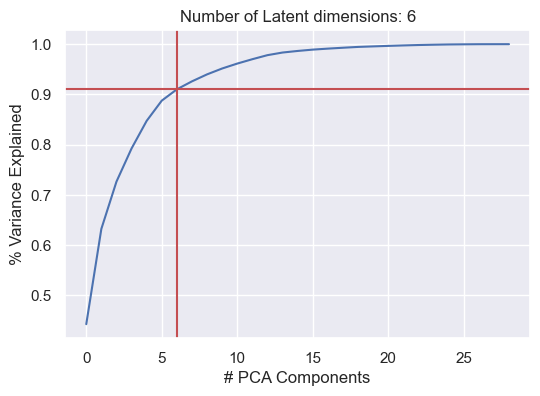

In [48]:
threshold = .9
idx = np.where(cumulative_var_expl>threshold)[0][0]
exp_var = np.cumsum(pca.explained_variance_ratio_)

sns.lineplot(cumulative_var_expl)
plt.axvline(idx, c='r')
plt.axhline(exp_var[idx], c='r')
plt.xlabel('# PCA Components')
plt.ylabel('% Variance Explained')
plt.title('Number of Latent dimensions: ' + str(idx))

This indicates that out of all 29 variables, with 6 we reach just 90% of explanation.

Text(0, 0.5, 'RMSE')

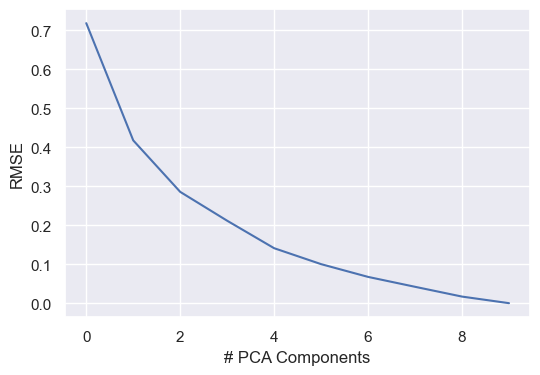

In [49]:
sns.lineplot(RMSE)
plt.xlabel('# PCA Components')
plt.ylabel('RMSE')

We observve the elbow at between 2 and 4 components. 

To determine which columns preserve the most variance, you can analyze the loadings of each feature in the principal components. The loadings represent the contribution of each original feature to the principal components. 

In [50]:
feature_names = dfX.columns

n_features = pca.n_features_in_

loadings = pca.components_

pc_list = [f'PC{i}' for i in list(range(1, n_features))]
pc_loadings = dict(zip(pc_list, loadings))

loadings_df = pd.DataFrame.from_dict(pc_loadings)
loadings_df['feature_names'] = feature_names
loadings_df = loadings_df.set_index('feature_names')
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29
feature_names,,,,,,,,,,,,,,,,,,,,,
mean radius,0.218902,-0.233857,-0.008531,0.041409,0.037786,0.018741,-0.124088,-0.007452,-0.223110,0.095486,...,-0.049699,-0.068570,0.072929,-0.098553,0.182579,0.019226,-0.129476,-0.131527,0.211194,0.211460
mean texture,0.103725,-0.059706,0.064550,-0.603050,-0.049469,-0.032179,0.011400,0.130675,0.112699,0.240934,...,-0.244135,0.448369,0.094801,-0.000555,-0.098787,-0.084746,-0.024557,-0.017357,-0.000066,-0.010534
mean perimeter,0.227537,-0.215181,-0.009314,0.041983,0.037375,0.017308,-0.114477,-0.018687,-0.223739,0.086386,...,-0.017665,-0.069769,0.075160,-0.040245,0.116649,-0.027015,-0.125256,-0.115415,0.084338,0.383826
mean area,0.220995,-0.231077,0.028700,0.053434,0.010331,-0.001888,-0.051653,0.034674,-0.195586,0.074956,...,-0.090144,-0.018443,0.097566,0.007777,-0.069848,0.210041,0.362727,0.466612,-0.272508,-0.422795
mean smoothness,0.142590,0.186113,-0.104292,0.159383,-0.365089,-0.286374,-0.140669,-0.288975,0.006425,-0.069293,...,0.017101,-0.119492,0.063823,-0.020666,-0.068697,-0.028955,-0.037004,0.069690,0.001479,-0.003435
mean compactness,0.239285,0.151892,-0.074092,0.031795,0.011704,-0.014131,0.030918,-0.151396,-0.167841,0.012936,...,0.488686,0.192621,-0.098078,0.052360,0.104136,-0.396623,0.262808,0.097749,-0.005463,-0.041017
mean concavity,0.258400,0.060165,0.002734,0.019123,0.086375,-0.009344,-0.107520,-0.072827,0.040591,-0.135602,...,-0.033387,0.005572,-0.185212,0.324870,-0.044741,0.096977,-0.548876,0.364808,0.045539,-0.010015
mean concave points,0.260854,-0.034768,-0.025564,0.065336,-0.043861,-0.052050,-0.150482,-0.152322,-0.111971,0.008055,...,-0.235408,-0.009424,-0.311852,-0.051409,-0.084028,0.186452,0.387643,-0.454699,-0.008883,-0.004207
mean symmetry,0.138167,0.190349,-0.040240,0.067125,-0.305941,0.356458,-0.093891,-0.231531,0.256040,0.572069,...,0.026069,-0.086938,-0.018407,-0.051201,-0.019339,0.024584,-0.016044,-0.015165,0.001433,-0.007570


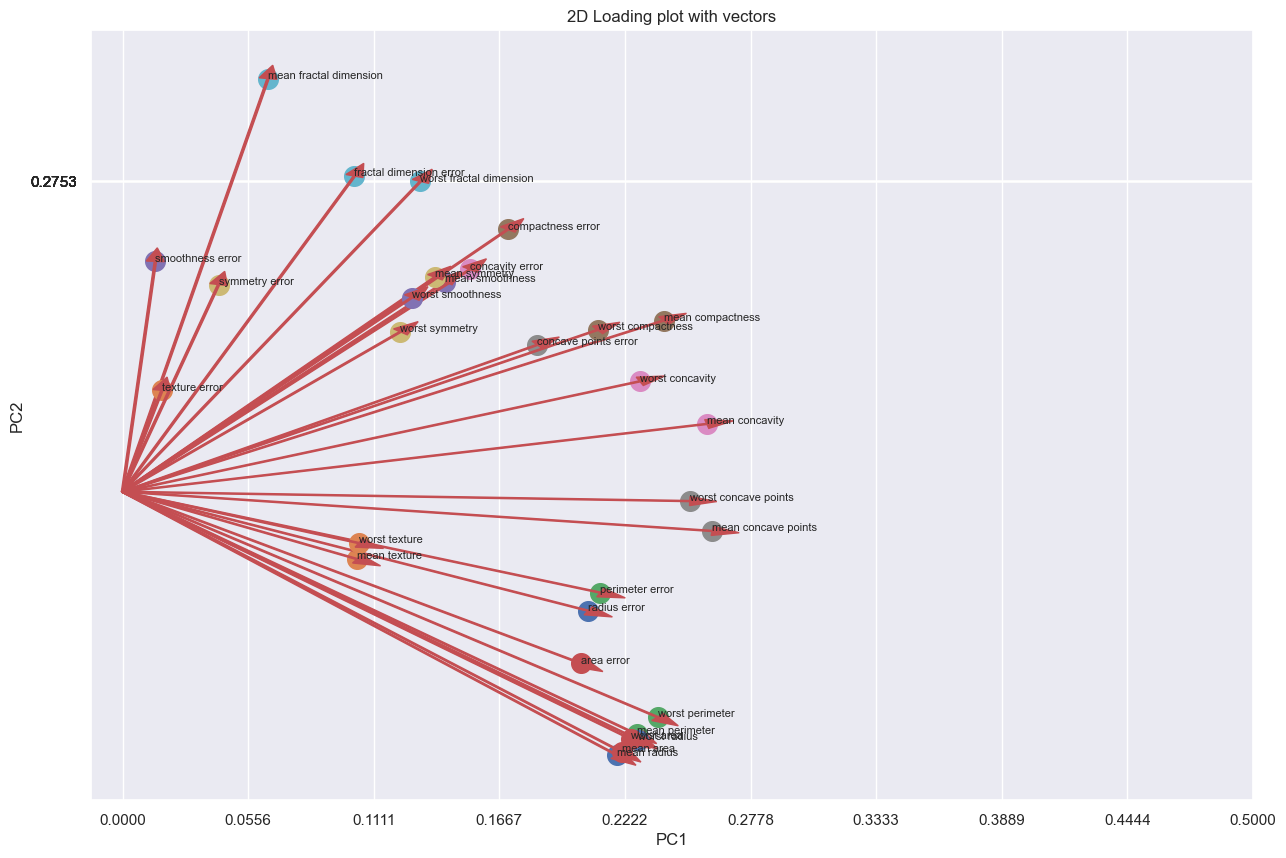

In [51]:
xs = loadings_df.iloc[:, 0]
ys = loadings_df.iloc[:, 1]
 
plt.figure(figsize=(15,10))
# Plot the loadings on a scatterplot
for i, varnames in enumerate(feature_names):
    plt.scatter(xs.iloc[i], ys.iloc[i], s=200)
    plt.arrow(
        0, 0, # coordinates of arrow base
        xs.iloc[i], # length of the arrow along x
        ys.iloc[i], # length of the arrow along y
        color='r', 
        head_width=0.008
        )
    plt.text(xs.iloc[i], ys.iloc[i], varnames, fontsize=8)
 
# Define the axes
ymin = np.min(ys.iloc[i])
ymax = np.max(ys.iloc[i])

xticks = np.linspace(0, 0.5, num=10)
yticks = np.linspace(ymin, ymax, num=10)
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('PC1')
plt.ylabel('PC2')

# Show plot
plt.title('2D Loading plot with vectors')
plt.show()

In [52]:
sorted_components = sorted(enumerate(var_explained), key=lambda x: x[1], reverse=True)
sorted_components

[(0, 0.44272025607526383),
 (1, 0.18971182044033064),
 (2, 0.09393163257431361),
 (3, 0.06602134915470156),
 (4, 0.05495768492346277),
 (5, 0.04024522039883344),
 (6, 0.02250733712982508),
 (7, 0.015887238000213275),
 (8, 0.013896493745591093),
 (9, 0.011689781894131496),
 (10, 0.00979718987598018),
 (11, 0.008705379007378831),
 (12, 0.008045249871967313),
 (13, 0.005233657454926348),
 (14, 0.0031378321676273947),
 (15, 0.0026620933651523163),
 (16, 0.0019799679253242734),
 (17, 0.0017539594502263619),
 (18, 0.0016492530592251682),
 (19, 0.0010386467483387016),
 (20, 0.000999096463700251),
 (21, 0.000914646751054346),
 (22, 0.0008113612588991058),
 (23, 0.0006018335666716714),
 (24, 0.0005160423791651867),
 (25, 0.00027258799547750075),
 (26, 0.00023001546250596454),
 (27, 5.297792903809431e-05),
 (28, 2.496010324687654e-05)]

# Classification example with KNN

We're going to choose 6 as the number of latent dimensions which allow us to retain 90% of variance of the dataset. 

In [53]:
#useful function that help us with the dataframes
def dataset_to_pandas(data, target): 
    data  = pd.DataFrame(data, columns=["X" + str(i + 1) for i in range(data.shape[1])])
    inputs = data.columns
    data["Y"] = target
    output = "Y"
    return data, inputs, output

In [55]:
data_std = StandardScaler().fit_transform(dataset.data)
XTR, XTS, YTR, YTS = train_test_split(data_std, dataset.target, test_size=0.2,random_state=1,  stratify = dataset.target)

In [56]:
# Perform PCA in all datasets
subspace_dim = 6
pca5 = PCA(subspace_dim)
XTR_pca = pca5.fit_transform(XTR)
XTS_pca = pca5.fit_transform(XTS)

In [57]:
accrcies = []

# Select the values of k
k_start = 2
k_stop = 50
k_step = 1

k_values = np.arange(start=k_start, stop=k_stop, step=k_step).astype("int")

# Loop through k values, fitting models and getting accuracies
train_data, train_inputs, train_outputs = dataset_to_pandas(XTR_pca, YTR)

for k in k_values:
    knn_pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                        ('knn', KNeighborsClassifier(n_neighbors=k))])
    knn_pipe.fit(train_data[train_inputs], train_data[train_outputs])
    
    accrcies.append(knn_pipe.score(train_data[train_inputs], train_data[train_outputs]))

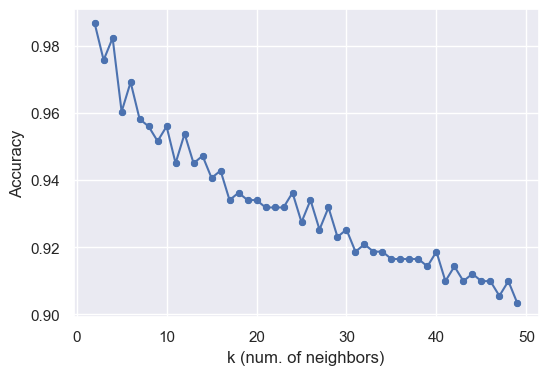

In [58]:
accrcies = np.array(accrcies)
# Plot accuracies vs k
ax_acc = sns.scatterplot(x = k_values, y = accrcies)
sns.lineplot(x = k_values, y = accrcies, ax=ax_acc)
ax_acc.set(xlabel ="k (num. of neighbors)", ylabel = "Accuracy");       

* We need to find the best value of k for classification. 
* We are going to create a pipeline that implements a grid search with 10-fold cross validation to try to estimate
* the optimal value of k in a KNN model for this dataset.

We begin by defining the k values that we want to use. We will go from 3 to the training data size in 15 steps.

In [59]:
k_values = np.arange(1, 50)
hyp_grid = {'knn__n_neighbors': k_values} 

In [60]:
knn_pipe_hyper = Pipeline(steps=[('scaler', StandardScaler()), 
                        ('knn', KNeighborsClassifier())])

In [62]:

num_folds = 10

knn_gridCV = GridSearchCV(estimator=knn_pipe_hyper, 
                        param_grid=hyp_grid, 
                        cv=num_folds,
                        return_train_score=True)

In [63]:
knn_gridCV.fit(XTR_pca, YTR) 

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             return_train_score=True)

In [64]:
knn_gridCV.best_params_

{'knn__n_neighbors': 6}

Accuracy score after implementing Cross Validation and the 6 clusters. 

In [65]:
knn_gridCV.score(XTR_pca, YTR), knn_gridCV.score(XTS_pca, YTS)

(0.9692307692307692, 0.8947368421052632)

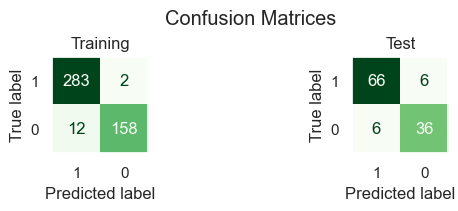

In [67]:

model = knn_gridCV
fig = plt.figure(constrained_layout=True, figsize=(6, 2))
spec = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(spec[0, 0]);ax1.set_title('Training'); ax1.grid(False)
ax3 = fig.add_subplot(spec[0, 1]);ax3.set_title('Test'); ax3.grid(False)
ConfusionMatrixDisplay.from_estimator(model, XTR_pca, YTR, cmap="Greens", colorbar=False, ax=ax1, labels=[1, 0])
ConfusionMatrixDisplay.from_estimator(model, XTS_pca, YTS, cmap="Greens", colorbar=False, ax=ax3, labels=[1, 0])
plt.suptitle("Confusion Matrices")
plt.show(); 

<Figure size 1200x1200 with 0 Axes>

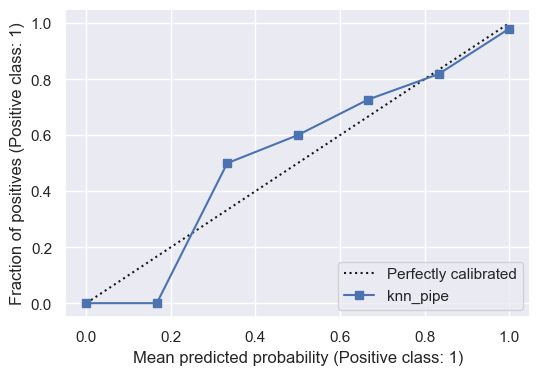

In [69]:
plt.figure(constrained_layout=False, figsize=(12, 12))
fig, ax = plt.subplots()
CalibrationDisplay.from_estimator(knn_gridCV, XTS_pca, YTS, n_bins=10,
                                  name="knn_pipe", pos_label = 1, ax=ax)

# 3. Assessing PCA Effectiveness

<Figure size 500x500 with 0 Axes>

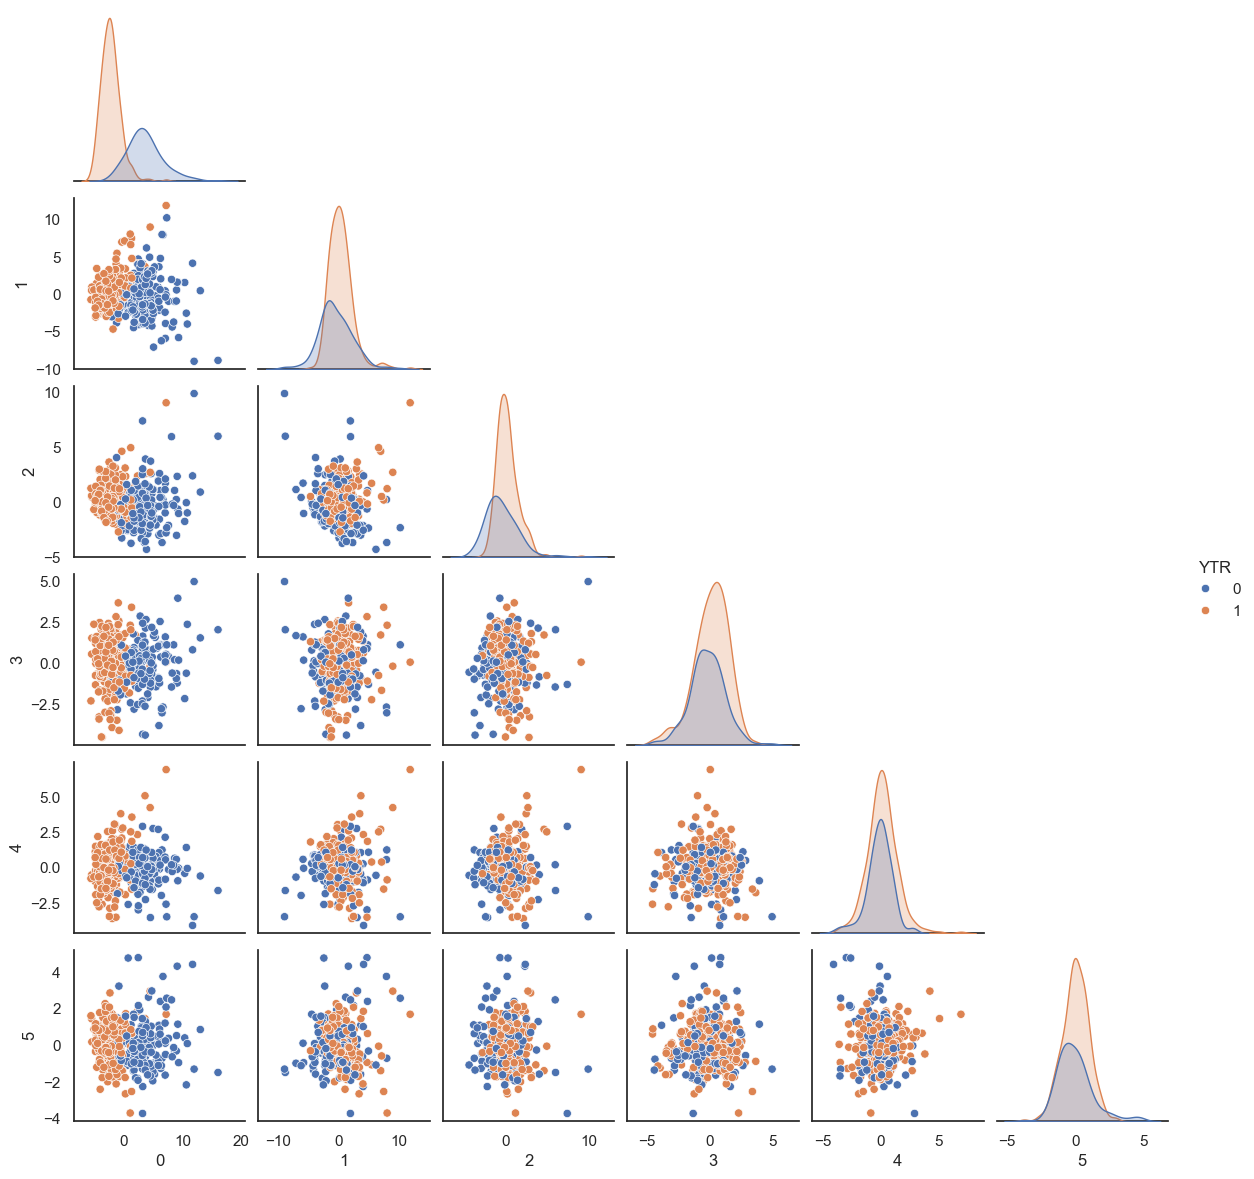

In [71]:
plt.figure(figsize=(5,5))
sns.set_style("white")
plt_df = XTR_pca.copy()
plt_df = pd.DataFrame(plt_df)
plt_df["YTR"] = YTR
sns.pairplot(plt_df, hue="YTR", corner=True, height=2)

In [72]:
plt_df.head()

,0,1,2,3,4,5,YTR
0,6.712882,7.916042,0.229530,-2.676302,0.554491,3.743102,0
1,3.219140,-1.867974,0.074330,0.571550,-1.357775,0.736827,0
2,2.258338,1.949063,-2.039379,-0.058310,-0.541140,-0.285016,0
3,2.192547,0.978001,-1.832129,-0.506342,-0.519708,0.313856,0
4,-2.474339,0.790978,0.387317,-0.169715,-1.023257,-0.896268,1


What this shows us is the relation/correlation between each feature after having applied the PCA. 

Since PCA transforms the original variables into a new set of variables (the principal components) that are linearly uncorrelated with each other, the pairplot can reveal interesting aspects of the data's structure in the reduced-dimensional space.

* The peak of each variable has to do with the volume of data that there is for that specific class. $\rightarrow$ Higher peaks, unbalanced data. 
* We can also observe that there is no visible correlation or patterns between each other $\rightarrow$ Orthogonal eigenvectors.

In [73]:
feature_names = dfX.columns
n_features = pca5.n_features_in_
loadings = pca5.components_
pc_list = [f'PC{i}' for i in list(range(1, n_features))]
pc_loadings = dict(zip(pc_list, loadings))

loadings_df = pd.DataFrame.from_dict(pc_loadings)
loadings_df['feature_names'] = feature_names
loadings_df = loadings_df.set_index('feature_names')
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6
feature_names,,,,,,
mean radius,0.235859,-0.219335,0.040602,0.075415,0.109844,-0.015291
mean texture,0.126882,-0.064979,0.333062,-0.222233,-0.425155,0.039304
mean perimeter,0.242582,-0.196032,0.033737,0.071963,0.100008,-0.012046
mean area,0.238539,-0.205447,0.069581,0.065360,0.124781,0.001528
mean smoothness,0.139038,0.192159,-0.178235,-0.357262,0.246447,0.244028
mean compactness,0.225373,0.174889,-0.119538,-0.010990,-0.072753,0.002753
mean concavity,0.243715,0.078982,-0.049001,0.048590,-0.046422,0.038488
mean concave points,0.269977,0.004960,-0.031728,-0.001652,0.068333,0.021863
mean symmetry,0.142077,0.230213,-0.125540,-0.172379,0.150894,-0.558714


In [74]:
accrcies = []

# Select the values of k
k_start = 2
k_stop = 50
k_step = 1

k_values = np.arange(start=k_start, stop=k_stop, step=k_step).astype("int")

# Loop through k values, fitting models and getting accuracies

train_data, train_inputs, train_outputs = dataset_to_pandas(XTR, YTR)

for k in k_values:
    knn_pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                        ('knn', KNeighborsClassifier(n_neighbors=k))])
    knn_pipe.fit(train_data[train_inputs], train_data[train_outputs])
    
    accrcies.append(knn_pipe.score(train_data[train_inputs], train_data[train_outputs]))

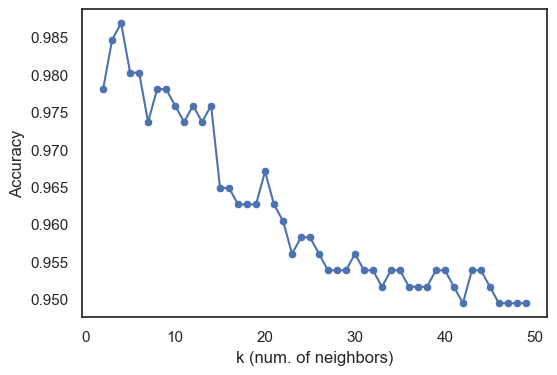

In [75]:
accrcies = np.array(accrcies)
# Plot accuracies vs k
ax_acc = sns.scatterplot(x = k_values, y = accrcies)
sns.lineplot(x = k_values, y = accrcies, ax=ax_acc)
ax_acc.set(xlabel ="k (num. of neighbors)", ylabel = "Accuracy");  

In [76]:
k_values = np.arange(1, 50)
hyp_grid = {'knn__n_neighbors': k_values} 

In [77]:
num_folds = 10

knn_gridCV = GridSearchCV(estimator=knn_pipe_hyper, 
                        param_grid=hyp_grid, 
                        cv=num_folds,
                        return_train_score=True)

In [78]:
knn_gridCV.fit(XTR, YTR) 

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             return_train_score=True)

In [79]:
knn_gridCV.best_params_

{'knn__n_neighbors': 7}

In [80]:
knn_gridCV.score(XTR, YTR), knn_gridCV.score(XTS, YTS)

(0.9736263736263736, 0.9736842105263158)

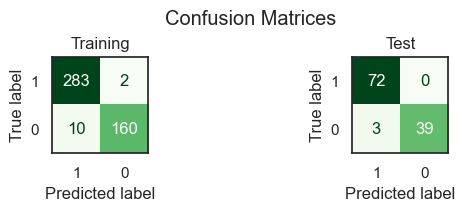

In [81]:
model = knn_gridCV
fig = plt.figure(constrained_layout=True, figsize=(6, 2))
spec = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(spec[0, 0]);ax1.set_title('Training'); ax1.grid(False)
ax3 = fig.add_subplot(spec[0, 1]);ax3.set_title('Test'); ax3.grid(False)
ConfusionMatrixDisplay.from_estimator(model, XTR, YTR, cmap="Greens", colorbar=False, ax=ax1, labels=[1, 0])
ConfusionMatrixDisplay.from_estimator(model, XTS, YTS, cmap="Greens", colorbar=False, ax=ax3, labels=[1, 0])
plt.suptitle("Confusion Matrices")
plt.show(); 

<Figure size 1200x1200 with 0 Axes>

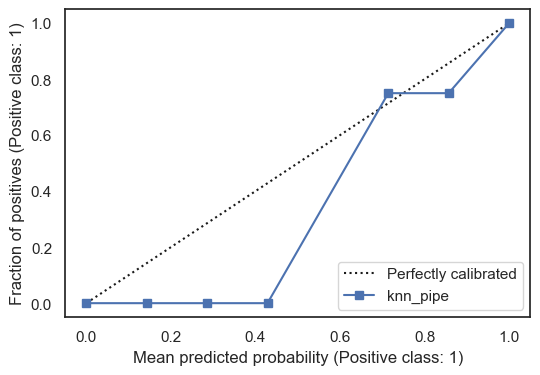

In [82]:
plt.figure(constrained_layout=False, figsize=(12, 12))
fig, ax = plt.subplots()
CalibrationDisplay.from_estimator(knn_gridCV, XTS, YTS, n_bins=10,
                                  name="knn_pipe", pos_label = 1, ax=ax)

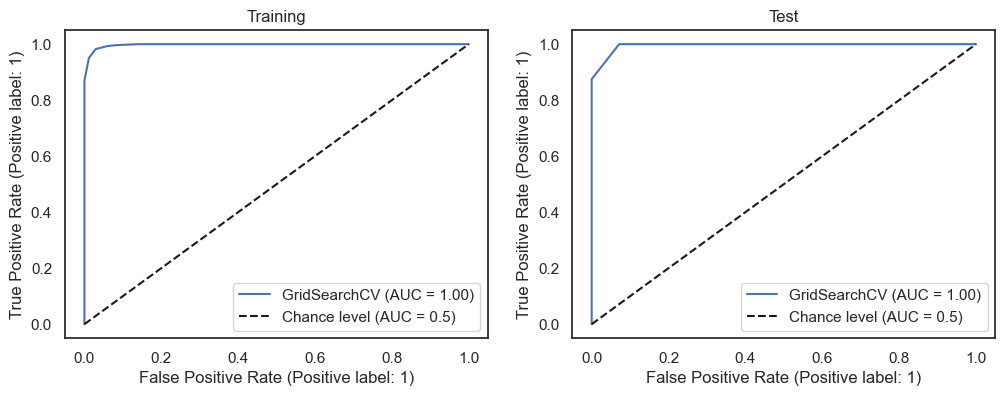

In [83]:
fig = plt.figure(figsize=(12, 4))
spec = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(spec[0, 0]);ax1.set_title('Training')
ax2 = fig.add_subplot(spec[0, 1]);ax2.set_title('Test')
RocCurveDisplay.from_estimator(knn_gridCV, XTR, YTR, plot_chance_level=True, ax=ax1)
RocCurveDisplay.from_estimator(knn_gridCV, XTS, YTS, plot_chance_level=True, ax=ax2);
plt.show(); 

# 4. Selecting singular components, rather than doing PCA. 

This removes the latent vector base, and gives you much more predicative results. 

In [84]:
dfX.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

In [85]:
x = dfX[['worst concave points', 'mean fractal dimension']]
dfX_reduced = x.assign(target=dfY)
dfX_reduced.head()

,worst concave points,mean fractal dimension,target
0,0.2654,0.07871,0
1,0.1860,0.05667,0
2,0.2430,0.05999,0
3,0.2575,0.09744,0
4,0.1625,0.05883,0


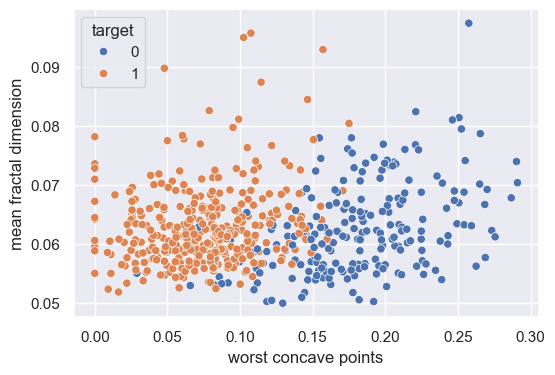

In [86]:
sns.set_theme(rc={'figure.figsize':(6, 4)})
sns.scatterplot(dfX_reduced, x = 'worst concave points', y = 'mean fractal dimension', hue='target');

In [87]:
XTR, XTS, YTR, YTS = train_test_split(x, dfY, test_size=0.2,random_state=1,  stratify = dataset.target)

In [88]:
k_values = np.arange(1, 50)
hyp_grid = {'knn__n_neighbors': k_values} 
knn_pipe_hyper = Pipeline(steps=[('scaler', StandardScaler()), 
                        ('knn', KNeighborsClassifier())])

In [89]:
num_folds = 10

knn_gridCV = GridSearchCV(estimator=knn_pipe_hyper, 
                        param_grid=hyp_grid, 
                        cv=num_folds,
                        return_train_score=True)

In [90]:
knn_gridCV.fit(XTR, YTR.values.ravel()) 

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             return_train_score=True)

In [91]:
knn_gridCV.best_params_

{'knn__n_neighbors': 15}

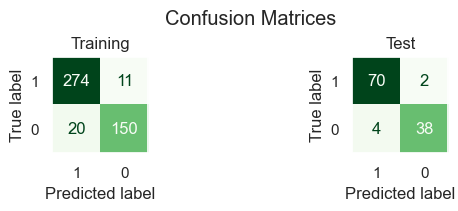

In [92]:
model = knn_gridCV
fig = plt.figure(constrained_layout=True, figsize=(6, 2))
spec = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(spec[0, 0]); ax1.set_title('Training'); ax1.grid(False)
ax3 = fig.add_subplot(spec[0, 1]); ax3.set_title('Test'); ax3.grid(False)
ConfusionMatrixDisplay.from_estimator(model, XTR, YTR, cmap="Greens", colorbar=False, ax=ax1, labels=[1, 0])
ConfusionMatrixDisplay.from_estimator(model, XTS, YTS, cmap="Greens", colorbar=False, ax=ax3, labels=[1, 0])
plt.suptitle("Confusion Matrices")
plt.show(); 

<Figure size 1200x1200 with 0 Axes>

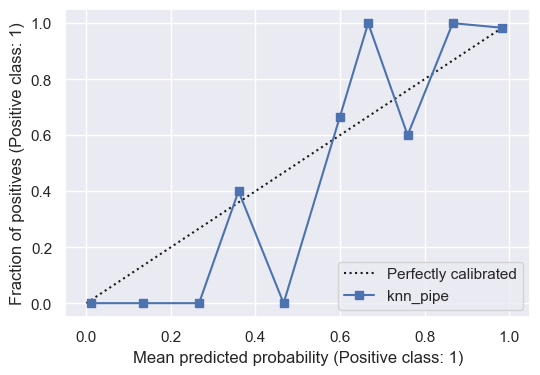

In [93]:
plt.figure(constrained_layout=False, figsize=(12, 12))
fig, ax = plt.subplots()
CalibrationDisplay.from_estimator(knn_gridCV, XTS, YTS, n_bins=10, name="knn_pipe", pos_label = 1, ax=ax)

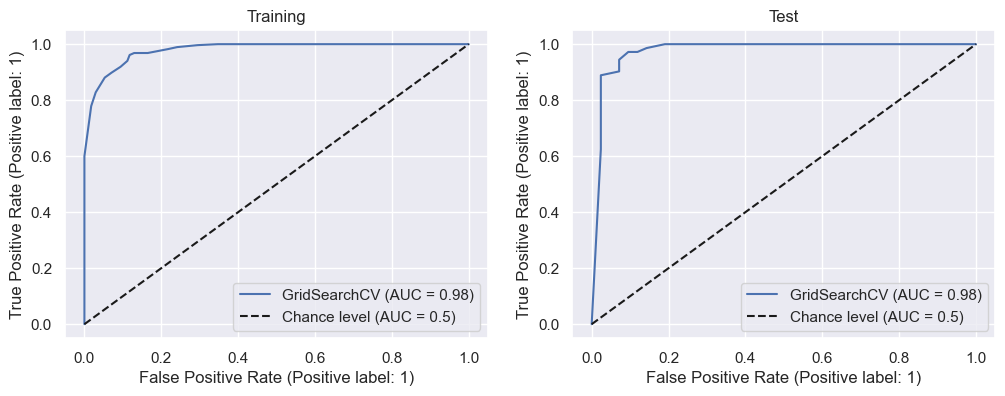

In [94]:
fig = plt.figure(figsize=(12, 4))
spec = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(spec[0, 0]);ax1.set_title('Training')
ax2 = fig.add_subplot(spec[0, 1]);ax2.set_title('Test')
RocCurveDisplay.from_estimator(knn_gridCV, XTR, YTR, plot_chance_level=True, ax=ax1)
RocCurveDisplay.from_estimator(knn_gridCV, XTS, YTS, plot_chance_level=True, ax=ax2);
plt.show(); 